To reduce rising loss and enhance the confusion matrix, I worked on AE and classifier.
Even with bare eyes, it's difficult to tell the difference between classes 5 and 6. Thats why we will merge two classes as a new class. AECL_7class_090522 

In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from PIL import ImageFile, Image
ImageFile.LOAD_TRUNCATED_IMAGES = True
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose

BATCH_SIZE= 16
num_classes = 8

In [10]:
onehot = {
     'Tesettür Elbise': [1, 0, 0, 0, 0, 0, 0, 0],
     'Tunik': [0, 1, 0, 0, 0, 0, 0, 0],
     'Şal':  [0, 0, 1, 0, 0, 0, 0, 0],
     'Eşarp': [0, 0, 0, 1, 0, 0, 0, 0],
     'Takım': [0, 0, 0, 0, 1, 0, 0, 0],
     "Kap / Pardesü":[0, 0, 0, 0, 0, 1, 0, 0],
     "Ferace":[0, 0, 0, 0, 0, 0, 1, 0],
     "T-shirt":[0, 0, 0, 0, 0, 0, 0, 1]
     }
#One hot encoding of labels

In [6]:
df = pd.read_csv(r"D:\Tubitak_data\resnet-10classes\out1.csv")
df.drop(columns=["Unnamed: 0"], inplace=True) #it was index column.
poselist = df.to_numpy() #contains productid and labels 

In [7]:
filenames = os.listdir("D:/Tubitak_data/ZeroOnePose/")
file_list = []

for each in poselist:
    filename = str(each[0])+".npy"
    if filename in filenames:
        file_list.append(each)

In [4]:
class AEDataGenerator(tf.keras.utils.Sequence):
    
    def __init__(self, img_list, batch_size= BATCH_SIZE, dim=(32,32,32), n_channels= 1, n_classes=8, shuffle= True):
        self.dim = dim
        self.batch_size = batch_size
        self.img_list = img_list
        self.n_classes = n_classes
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()
        self.n = 0
    
    def __len__(self):
        return int(np.floor(len(self.img_list) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        img_list_temp = [self.img_list[k] for k in indexes]

        i,l = self.__data_generation(img_list_temp)
        return i,[i,l]

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.img_list))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __next__(self):
        if self.n >= self.max:
            self.n = 0
        result = self.__getitem__(self.n)
        self.n += 1
        return result

    def __data_generation(self, img_list_temp):   
        #X = np.empty((self.batch_size, 66,))
        I = np.empty((self.batch_size, im_height,im_width,3))
        L = np.empty((self.batch_size, num_classes))
        
        for i, each in enumerate(img_list_temp):                
            #X[i,] = np.load('D:/Tubitak_data/ZeroOnePose/'+ str(each[1]) +".npy", allow_pickle=True)
            
            image = Image.open('D:/Tubitak_data/dataset/'+ str( each[0] )+ ".jpg")#.convert('L')
            image = np.array(  (image.convert('RGB')).resize((im_width,im_height)) ) 
            
            I[i,] = image / 255.0
            L[i] = onehot[ each[1]]
         
        return I, L
    

In [92]:
params = {'dim': (32,32,32),
          'batch_size': BATCH_SIZE,
          'n_classes': num_classes,
          'n_channels': 1,
          'shuffle': True}

# Generators
train_gen = AEDataGenerator( file_list[:40000], **params) #train generator
val_gen = AEDataGenerator( file_list[40000:48040], **params)


In [101]:
im_height= 136
im_width = 100
im_size = (im_height,im_width,3)

# encoder
input_layer = tf.keras.Input(shape=im_size)
encoder = Conv2D(16, (3, 3), activation='relu', padding='same', strides=2)(input_layer)
encoder = Conv2D(8, (3, 3), activation='relu', padding='same', strides=2, name="encoder")(encoder)

encoder_model = tf.keras.Model(input_layer, encoder, name="encoder")

# decoder
decoder = Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same')(encoder)
decoder = Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same')(decoder)
decoder = Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same', name="decoder")(decoder)

autoencoder = tf.keras.Model(input_layer, decoder, name="autoencoder")


In [102]:

clsf =  tf.keras.layers.Flatten( )(encoder)
clsf =  tf.keras.layers.Dense( 256, activation='relu')(clsf)
clsf =  tf.keras.layers.Dense( 128, activation='relu')(clsf)
y = tf.keras.layers.Dense(num_classes, activation= 'softmax', name="classifier")(clsf)


conv_ae_cl = tf.keras.Model(inputs= input_layer,outputs= [decoder, y])

In [107]:
losses = {
    "classifier": "categorical_crossentropy",
    "decoder": "MeanSquaredError",
}
conv_ae_cl.compile( loss = losses,
                    metrics= ['accuracy'] , optimizer="adam")

history = conv_ae_cl.fit(train_gen, batch_size=BATCH_SIZE, epochs=20, validation_data=val_gen)

Epoch 1/20
1250/1250 [==============================] - 1568s 1s/step - loss: 1.0974 - decoder_loss: 0.0243 - classifier_loss: 1.0732 - decoder_accuracy: 0.6752 - classifier_accuracy: 0.6249 - val_loss: 0.9566 - val_decoder_loss: 0.0145 - val_classifier_loss: 0.9421 - val_decoder_accuracy: 0.6758 - val_classifier_accuracy: 0.6768
Epoch 2/20
1250/1250 [==============================] - 1360s 1s/step - loss: 0.7837 - decoder_loss: 0.0141 - classifier_loss: 0.7696 - decoder_accuracy: 0.5930 - classifier_accuracy: 0.7311 - val_loss: 0.9049 - val_decoder_loss: 0.0134 - val_classifier_loss: 0.8915 - val_decoder_accuracy: 0.5553 - val_classifier_accuracy: 0.6936
Epoch 3/20
1250/1250 [==============================] - 1371s 1s/step - loss: 0.6072 - decoder_loss: 0.0138 - classifier_loss: 0.5934 - decoder_accuracy: 0.5826 - classifier_accuracy: 0.7921 - val_loss: 0.8839 - val_decoder_loss: 0.0125 - val_classifier_loss: 0.8714 - val_decoder_accuracy: 0.5755 - val_classifier_accuracy: 0.7082
Epoc

In [108]:
conv_ae_cl.save("D:/Tubitak_data/results/convolutional_AE_CL_150422")

INFO:tensorflow:Assets written to: D:/Tubitak_data/results/convolutional_AE_CL_150422\assets


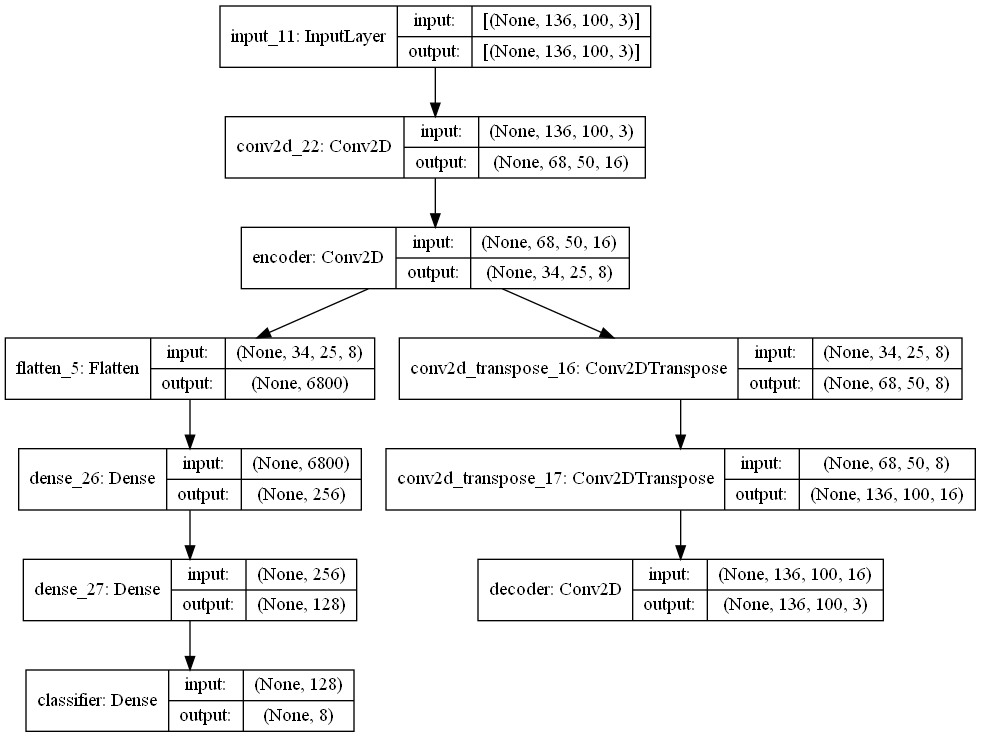

In [109]:
tf.keras.utils.plot_model(conv_ae_cl, to_file='model_test.png', show_shapes=True, show_layer_names=True)

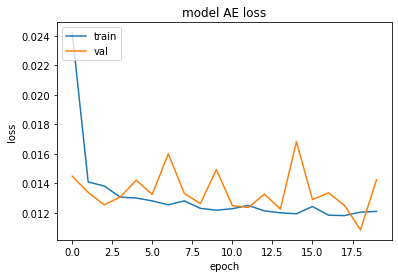

In [177]:
plt.plot(history.history['decoder_loss'])
plt.plot(history.history['val_decoder_loss'])
plt.title('model AE loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

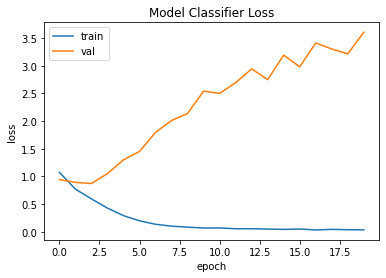

In [111]:
plt.plot(history.history['classifier_loss'])
plt.plot(history.history['val_classifier_loss'])
plt.title('Model Classifier Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

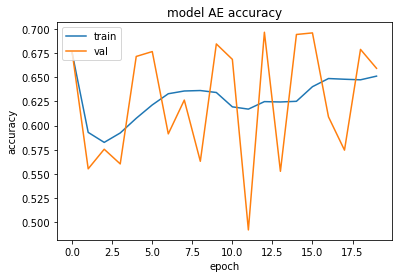

In [112]:
plt.plot(history.history['decoder_accuracy'])
plt.plot(history.history['val_decoder_accuracy'])
plt.title('model AE accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

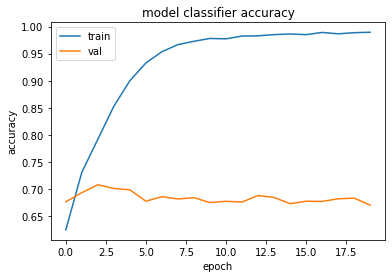

In [113]:
plt.plot(history.history['classifier_accuracy'])
plt.plot(history.history['val_classifier_accuracy'])
plt.title('model classifier accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [149]:
val_params= { 'dim': (32,32,32),
              'batch_size': BATCH_SIZE,
              'n_classes': 8,
              'n_channels': 1,
              'shuffle': False  }
test_gen =  AEDataGenerator( file_list[48040:], **val_params)
y_pred  = conv_ae_cl.predict(test_gen)


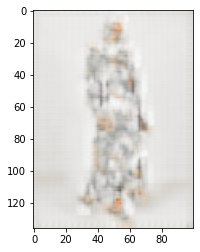

In [129]:
plt.imshow(np.array(y_pred[0][0]))

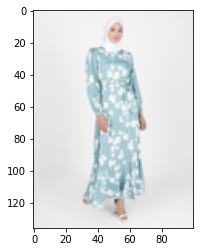

In [130]:
plt.imshow(test_gen.__getitem__(0)[0][0])

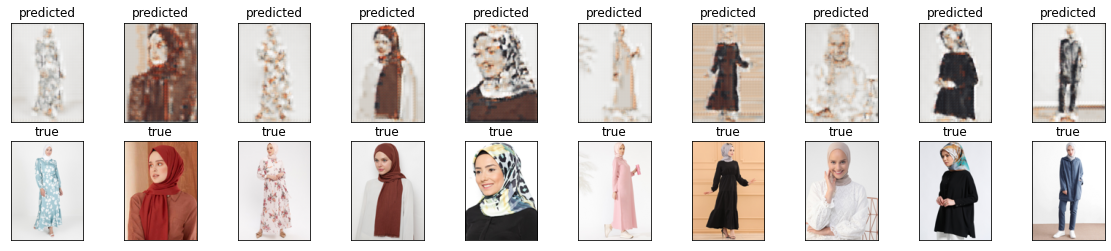

In [131]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(y_pred[0][i])
    plt.title("predicted")
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(test_gen.__getitem__(0)[0][i])
    plt.title("true")
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [160]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

dictNum = {
     'Tesettür Elbise': 0,
     'Tunik': 1,
     'Şal':  2,
     'Eşarp': 3,
     'Takım': 4,
     "Kap / Pardesü": 5,
     "Ferace": 6,
     "T-shirt": 7
     }

class_names = ['Tesettür Elbise', 'Tunik','Şal' ,'Eşarp', 'Takım', 'Kap / Pardesü','Ferace', 'T-shirt']

In [150]:
y_true_categs = np.array(file_list)[48040:,1]

y_true = [dictNum[each] for each in y_true_categs]

y_pred[1] = [np.argmax(each) for each in y_pred[1]]

In [151]:
print(y_true[:15])
y_pred[1][:15]

[0, 2, 0, 2, 3, 0, 0, 0, 1, 4, 1, 4, 2, 0, 3]


[0, 2, 0, 2, 3, 0, 6, 2, 1, 4, 1, 0, 2, 0, 2]

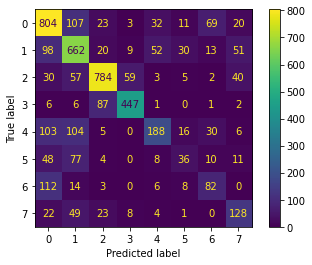

In [154]:
cm = confusion_matrix(y_true, y_pred[1], labels=[0,1,2,3,4,5,6,7])

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
        display_labels=[0,1,2,3,4,5,6,7])

disp.plot()
plt.show()

In [153]:
for i in range(len(y_true)-len(y_pred[1])):
    y_pred[1].append(8)

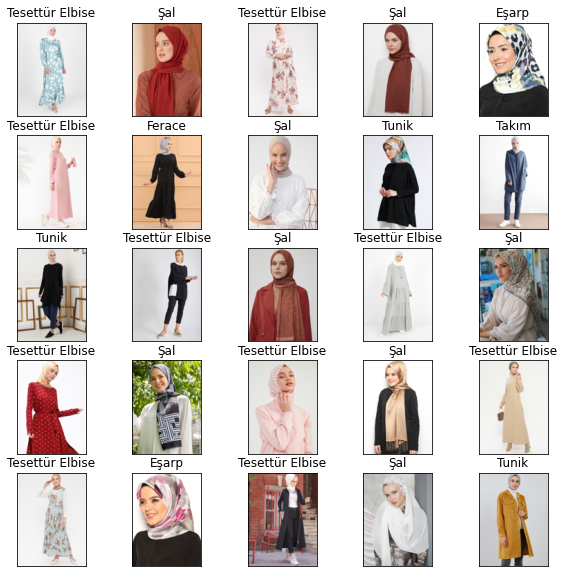

In [164]:
n = 25
plt.figure(figsize=(10,10))
for i in range(n):
    # display reconstruction
    ax = plt.subplot(5, 5, i + 1 )
    plt.imshow(test_gen.__getitem__(0)[0][i])
    plt.title(class_names[y_pred[1][i]])
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

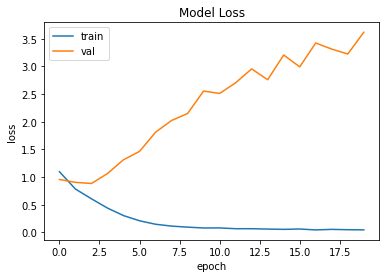

In [176]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Prev Results 

In [55]:
test_gen =  AEDataGenerator( file_list[48040:], **params)
y_true  = conv_ae_cl.predict(test_gen)

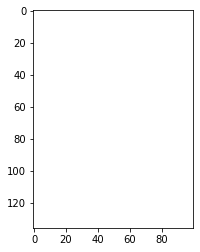

In [84]:
plt.imshow(np.array(y_true[0][10]))

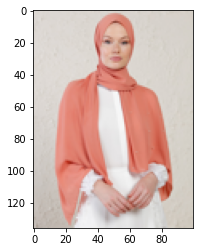

In [70]:
plt.imshow(test_gen.__getitem__(0)[0][0])

In [81]:
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

In [39]:
conv_ae_cl.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 136, 100, 3) 0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 68, 50, 16)   448         input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 34, 25, 8)    1160        conv2d_12[0][0]                  
__________________________________________________________________________________________________
flatten (Flatten)               (None, 6800)         0           conv2d_13[0][0]                  
____________________________________________________________________________________________

# Multitask ** loss

In [183]:
im_height= 136
im_width = 100
im_size = (im_height,im_width,3)

# encoder
input_layer = tf.keras.Input(shape=im_size)
encoder = Conv2D(16, (3, 3), activation='relu', padding='same', strides=2)(input_layer)
encoder = Conv2D(8, (3, 3), activation='relu', padding='same', strides=2, name="encoder")(encoder)

encoder_model = tf.keras.Model(input_layer, encoder, name="encoder")

# decoder
decoder = Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same')(encoder)
decoder = Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same')(decoder)
decoder = Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same', name="decoder")(decoder)

autoencoder = tf.keras.Model(input_layer, decoder, name="autoencoder")

clsf =  tf.keras.layers.Flatten( )(encoder)
clsf =  tf.keras.layers.Dense( 256, activation='relu')(clsf)
clsf =  tf.keras.layers.Dense( 128, activation='relu')(clsf)
y = tf.keras.layers.Dense(num_classes, activation= 'softmax', name="classifier")(clsf)


conv_ae_cl = tf.keras.Model(inputs= input_layer,outputs= [decoder, y])
losses = {
    "classifier": "categorical_crossentropy",
    "decoder": "MeanSquaredError",
}
conv_ae_cl.compile( loss = losses, loss_weights={"classifier":0.1, "decoder":1},
                    metrics= ['accuracy'] , optimizer="adam")

history = conv_ae_cl.fit(train_gen, batch_size=BATCH_SIZE, epochs=20, validation_data=val_gen)

Epoch 1/20
1250/1250 [==============================] - 1591s 1s/step - loss: 0.1355 - decoder_loss: 0.0214 - classifier_loss: 1.1403 - decoder_accuracy: 0.6734 - classifier_accuracy: 0.5983 - val_loss: 0.1059 - val_decoder_loss: 0.0069 - val_classifier_loss: 0.9897 - val_decoder_accuracy: 0.6912 - val_classifier_accuracy: 0.6555
Epoch 2/20
1250/1250 [==============================] - 1366s 1s/step - loss: 0.0906 - decoder_loss: 0.0060 - classifier_loss: 0.8465 - decoder_accuracy: 0.6776 - classifier_accuracy: 0.7090 - val_loss: 0.0976 - val_decoder_loss: 0.0055 - val_classifier_loss: 0.9204 - val_decoder_accuracy: 0.7119 - val_classifier_accuracy: 0.6884
Epoch 3/20
1250/1250 [==============================] - 1357s 1s/step - loss: 0.0753 - decoder_loss: 0.0055 - classifier_loss: 0.6985 - decoder_accuracy: 0.6871 - classifier_accuracy: 0.7591 - val_loss: 0.0919 - val_decoder_loss: 0.0051 - val_classifier_loss: 0.8678 - val_decoder_accuracy: 0.7719 - val_classifier_accuracy: 0.7143
Epoc

In [191]:
conv_ae_cl.save("D:/Tubitak_data/results/conv_ae_cl_model.h5")

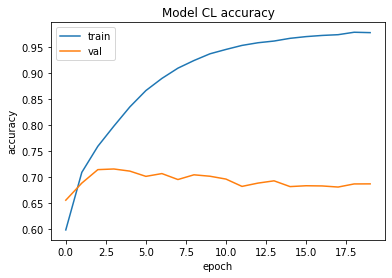

In [192]:
plt.plot(history.history['classifier_accuracy'])
plt.plot(history.history['val_classifier_accuracy'])
plt.title('Model CL accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

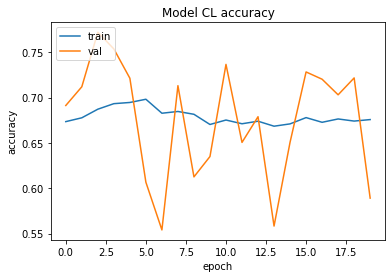

In [193]:
plt.plot(history.history['decoder_accuracy'])
plt.plot(history.history['val_decoder_accuracy'])
plt.title('Model AE accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

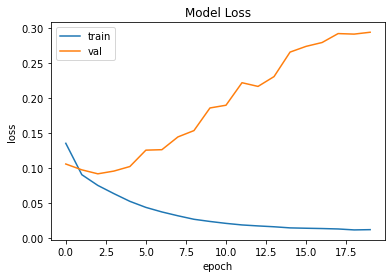

In [184]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [185]:
test_gen =  AEDataGenerator( file_list[48040:], **params)
y_true  = conv_ae_cl.predict(test_gen)

y_pred  = conv_ae_cl.predict(test_gen)
y_true_categs = np.array(file_list)[48040:,1]

y_true = [dictNum[each] for each in y_true_categs]

y_pred[1] = [np.argmax(each) for each in y_pred[1]]

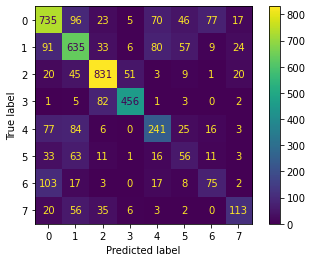

In [188]:
cm = confusion_matrix(y_true, y_pred[1], labels=[0,1,2,3,4,5,6,7])

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
        display_labels=[0,1,2,3,4,5,6,7])

disp.plot()
plt.show()

In [189]:
for i in range(len(y_true)-len(y_pred[1])):
    y_pred[1].append(8)

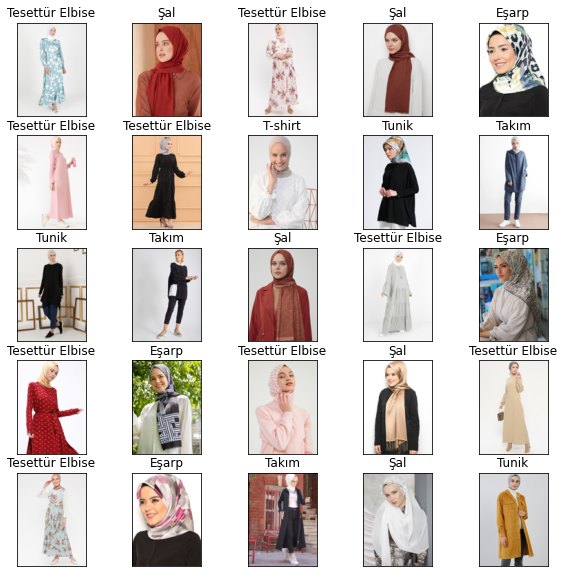

In [197]:
n = 25
plt.figure(figsize=(10,10))
for i in range(n):
    # display reconstruction
    ax = plt.subplot(5, 5, i + 1 )
    plt.imshow(test_gen.__getitem__(0)[0][i])
    plt.title(class_names[y_pred[1][i]])
    plt.xlabel(class_names[y_true[i]] )
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [195]:
y_true[:5]

[0, 2, 0, 2, 3]

# After 19/04/2022 meeting
* dropout ekle
* modeli küçült

In [6]:
params = {'dim': (32,32,32),
          'batch_size': BATCH_SIZE,
          'n_classes': num_classes,
          'n_channels': 1,
          'shuffle': True}

# Generators
train_gen = AEDataGenerator( file_list[:40000], **params) #train generator
val_gen = AEDataGenerator( file_list[40000:48040], **params)

im_height= 136
im_width = 100
im_size = (im_height,im_width,3)

# encoder
input_layer = tf.keras.Input(shape=im_size)
encoder = Conv2D(32, (3, 3), activation='relu', padding='same', strides=2)(input_layer)
encoder = Conv2D(8, (3, 3), activation='relu', padding='same', strides=2, name="encoder")(encoder)

encoder_model = tf.keras.Model(input_layer, encoder, name="encoder")

# decoder
decoder = Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same')(encoder)
decoder = Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same')(decoder)
decoder = Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same', name="decoder")(decoder)

autoencoder = tf.keras.Model(input_layer, decoder, name="autoencoder")

clsf =  tf.keras.layers.Flatten( )(encoder)
clsf = tf.keras.layers.Dropout(0.3)(clsf)
clsf =  tf.keras.layers.Dense( 256, activation='relu')(clsf)
clsf =  tf.keras.layers.Dense( 128, activation='relu')(clsf)
y = tf.keras.layers.Dense(num_classes, activation= 'softmax', name="classifier")(clsf)


conv_ae_cl = tf.keras.Model(inputs= input_layer,outputs= [decoder, y])
losses = {
    "classifier": "categorical_crossentropy",
    "decoder": "MeanSquaredError",
}
conv_ae_cl.compile( loss = losses, loss_weights={"classifier":0.1, "decoder":1},
                    metrics= ['accuracy'] , optimizer="adam")

history = conv_ae_cl.fit(train_gen, batch_size=BATCH_SIZE, epochs=20, validation_data=val_gen)

Epoch 1/20
2500/2500 [==============================] - 2545s 1s/step - loss: 0.1333 - decoder_loss: 0.0151 - classifier_loss: 1.1817 - decoder_accuracy: 0.6650 - classifier_accuracy: 0.5824 - val_loss: 0.1067 - val_decoder_loss: 0.0066 - val_classifier_loss: 1.0008 - val_decoder_accuracy: 0.7510 - val_classifier_accuracy: 0.6462
Epoch 2/20
2500/2500 [==============================] - 1408s 563ms/step - loss: 0.0967 - decoder_loss: 0.0059 - classifier_loss: 0.9078 - decoder_accuracy: 0.6799 - classifier_accuracy: 0.6853 - val_loss: 0.0956 - val_decoder_loss: 0.0051 - val_classifier_loss: 0.9044 - val_decoder_accuracy: 0.7415 - val_classifier_accuracy: 0.6850
Epoch 3/20
2500/2500 [==============================] - 1413s 565ms/step - loss: 0.0831 - decoder_loss: 0.0053 - classifier_loss: 0.7778 - decoder_accuracy: 0.6817 - classifier_accuracy: 0.7290 - val_loss: 0.0920 - val_decoder_loss: 0.0055 - val_classifier_loss: 0.8642 - val_decoder_accuracy: 0.5833 - val_classifier_accuracy: 0.705

In [7]:
conv_ae_cl.save("D:/Tubitak_data/results/AE_CL_Conv_E20.h5")

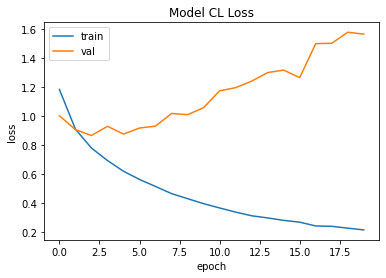

In [17]:
conv_ae_cl.save("D:/Tubitak_data/results/AE_CL_Conv_E20.h5")
plt.plot(history.history['classifier_loss'])
plt.plot(history.history['val_classifier_loss'])
plt.title('Model CL Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

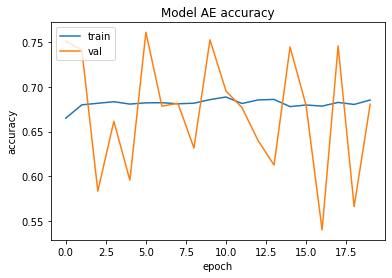

In [8]:
plt.plot(history.history['decoder_accuracy'])
plt.plot(history.history['val_decoder_accuracy'])
plt.title('Model AE accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

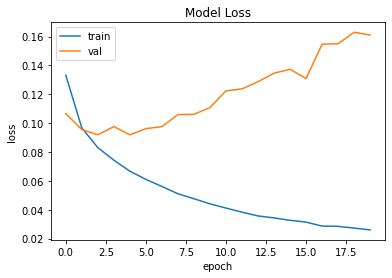

In [9]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

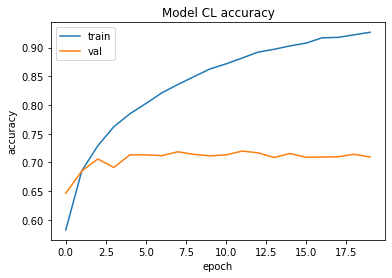

In [10]:
plt.plot(history.history['classifier_accuracy'])
plt.plot(history.history['val_classifier_accuracy'])
plt.title('Model CL accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

dictNum = {
     'Tesettür Elbise': 0,
     'Tunik': 1,
     'Şal':  2,
     'Eşarp': 3,
     'Takım': 4,
     "Kap / Pardesü": 5,
     "Ferace": 6,
     "T-shirt": 7
     }

class_names = ['Tesettür Elbise', 'Tunik','Şal' ,'Eşarp', 'Takım', 'Kap / Pardesü','Ferace', 'T-shirt']
val_params= { 'dim': (32,32,32),
              'batch_size': BATCH_SIZE,
              'n_classes': 8,
              'n_channels': 1,
              'shuffle': False  }
test_gen =  AEDataGenerator( file_list[48040:], **val_params)

y_pred  = conv_ae_cl.predict(test_gen)
y_true_categs = np.array(file_list)[48040:,1]

y_true = [dictNum[each] for each in y_true_categs]

y_pred[1] = [np.argmax(each) for each in y_pred[1]]

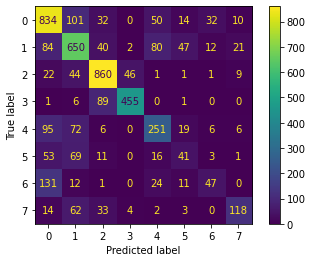

In [16]:
cm = confusion_matrix(y_true, y_pred[1], labels=[0,1,2,3,4,5,6,7])

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
        display_labels=[0,1,2,3,4,5,6,7])

disp.plot()
plt.show()

In [15]:
for i in range(len(y_true)-len(y_pred[1])):
    y_pred[1].append(8)

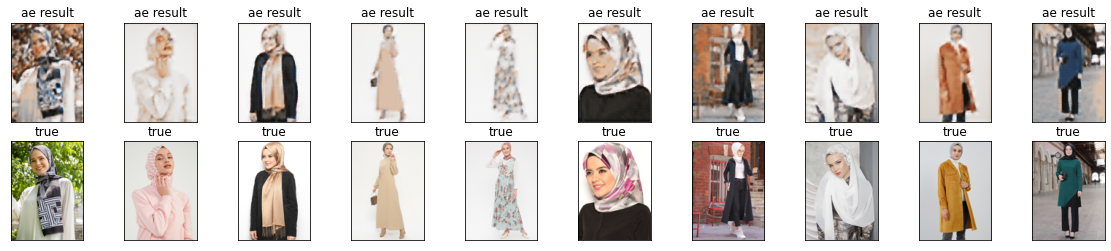

In [24]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(y_pred[0][i+16])
    plt.title("ae result")
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(test_gen.__getitem__(1)[0][i])
    plt.title("true")
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [27]:

c = np.in1d(y_true[:30],y_pred[1][:30])  

In [28]:
c

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True, False,  True,  True,
        True,  True,  True])

In [44]:
params = {'dim': (32,32,32),
          'batch_size': BATCH_SIZE,
          'n_classes': num_classes,
          'n_channels': 1,
          'shuffle': True}

# Generators
train_gen = AEDataGenerator( file_list[:40000], **params) #train generator
val_gen = AEDataGenerator( file_list[40000:48032], **params)

im_height= 136
im_width = 100
im_size = (im_height,im_width,3)

# encoder
input_layer = tf.keras.Input(shape=im_size)
encoder = Conv2D(32, (3, 3), activation='relu', padding='same', strides=2)(input_layer)
encoder = Conv2D(8, (3, 3), activation='relu', padding='same', strides=2, name="encoder")(encoder)

encoder_model = tf.keras.Model(input_layer, encoder, name="encoder")

# decoder
decoder = Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same')(encoder)
decoder = Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same')(decoder)
decoder = Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same', name="decoder")(decoder)

autoencoder = tf.keras.Model(input_layer, decoder, name="autoencoder")

clsf =  tf.keras.layers.Flatten( )(encoder)
clsf = tf.keras.layers.Dropout(0.5)(clsf)
clsf =  tf.keras.layers.Dense( 64, activation='relu')(clsf)
clsf =  tf.keras.layers.Dense( 32, activation='relu')(clsf)
y = tf.keras.layers.Dense(num_classes, activation= 'softmax', name="classifier")(clsf)


conv_ae_cl = tf.keras.Model(inputs= input_layer,outputs= [decoder, y])
losses = {
    "classifier": "categorical_crossentropy",
    "decoder": "MeanSquaredError",
}
conv_ae_cl.compile( loss = losses, loss_weights={"classifier":0.1, "decoder":1},
                    metrics= ['accuracy'] , optimizer="adam")


In [45]:
conv_ae_cl.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 136, 100, 3) 0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 68, 50, 32)   896         input_6[0][0]                    
__________________________________________________________________________________________________
encoder (Conv2D)                (None, 34, 25, 8)    2312        conv2d_5[0][0]                   
__________________________________________________________________________________________________
flatten_5 (Flatten)             (None, 6800)         0           encoder[0][0]                    
____________________________________________________________________________________________

In [46]:

history = conv_ae_cl.fit(train_gen, batch_size=BATCH_SIZE, epochs=20, validation_data=val_gen)

Epoch 1/20
2500/2500 [==============================] - 1415s 565ms/step - loss: 0.1355 - decoder_loss: 0.0129 - classifier_loss: 1.2259 - decoder_accuracy: 0.6585 - classifier_accuracy: 0.5612 - val_loss: 0.1104 - val_decoder_loss: 0.0062 - val_classifier_loss: 1.0422 - val_decoder_accuracy: 0.7385 - val_classifier_accuracy: 0.6381
Epoch 2/20
2500/2500 [==============================] - 1396s 558ms/step - loss: 0.1043 - decoder_loss: 0.0055 - classifier_loss: 0.9877 - decoder_accuracy: 0.6906 - classifier_accuracy: 0.6537 - val_loss: 0.0996 - val_decoder_loss: 0.0049 - val_classifier_loss: 0.9477 - val_decoder_accuracy: 0.7305 - val_classifier_accuracy: 0.6607
Epoch 3/20
2500/2500 [==============================] - 1397s 559ms/step - loss: 0.0964 - decoder_loss: 0.0051 - classifier_loss: 0.9131 - decoder_accuracy: 0.7038 - classifier_accuracy: 0.6831 - val_loss: 0.0988 - val_decoder_loss: 0.0053 - val_classifier_loss: 0.9347 - val_decoder_accuracy: 0.7646 - val_classifier_accuracy: 0.

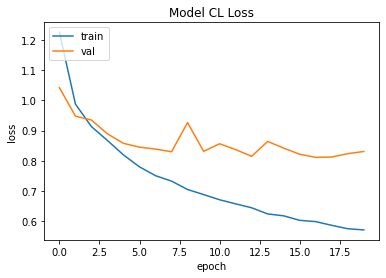

In [47]:
conv_ae_cl.save("D:/Tubitak_data/results/AE_CL_Conv_E20_Dout5.h5")
plt.plot(history.history['classifier_loss'])
plt.plot(history.history['val_classifier_loss'])
plt.title('Model CL Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

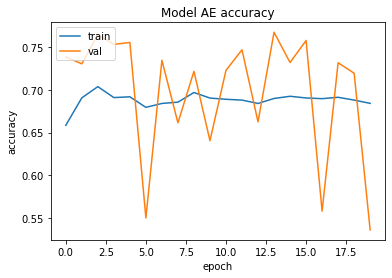

In [48]:
plt.plot(history.history['decoder_accuracy'])
plt.plot(history.history['val_decoder_accuracy'])
plt.title('Model AE accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

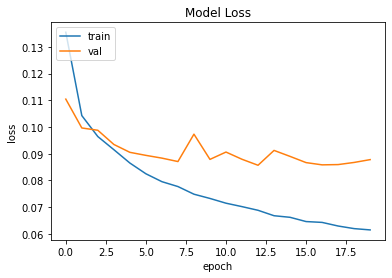

In [49]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [50]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

dictNum = {
     'Tesettür Elbise': 0,
     'Tunik': 1,
     'Şal':  2,
     'Eşarp': 3,
     'Takım': 4,
     "Kap / Pardesü": 5,
     "Ferace": 6,
     "T-shirt": 7
     }

class_names = ['Tesettür Elbise', 'Tunik','Şal' ,'Eşarp', 'Takım', 'Kap / Pardesü','Ferace', 'T-shirt']
val_params= { 'dim': (32,32,32),
              'batch_size': BATCH_SIZE,
              'n_classes': 8,
              'n_channels': 1,
              'shuffle': False  }
test_gen =  AEDataGenerator( file_list[48032:], **val_params)

y_pred  = conv_ae_cl.predict(test_gen)
y_true_categs = np.array(file_list)[48032:,1]

y_true = [dictNum[each] for each in y_true_categs]

y_pred[1] = [np.argmax(each) for each in y_pred[1]]

In [51]:
for i in range(len(y_true)-len(y_pred[1])):
    y_pred[1].append(8)

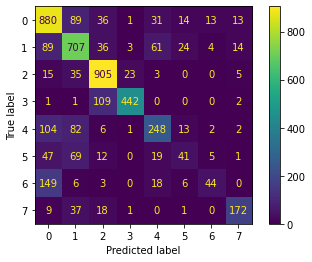

In [52]:
cm = confusion_matrix(y_true, y_pred[1], labels=[0,1,2,3,4,5,6,7])

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
        display_labels=[0,1,2,3,4,5,6,7])

disp.plot()
plt.show()

In [2]:
model =tf.keras.models.load_model("D:/Tubitak_data/results/AE_CL_Conv_E20_Dout5.h5")

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

im_height= 136
im_width = 100
im_size = (im_height,im_width,3)

dictNum = {
     'Tesettür Elbise': 0,
     'Tunik': 1,
     'Şal':  2,
     'Eşarp': 3,
     'Takım': 4,
     "Kap / Pardesü": 5,
     "Ferace": 6,
     "T-shirt": 7
     }

class_names = ['Tesettür Elbise', 'Tunik','Şal' ,'Eşarp', 'Takım', 'Kap / Pardesü','Ferace', 'T-shirt']
val_params= { 'dim': (32,32,32),
              'batch_size': BATCH_SIZE,
              'n_classes': 8,
              'n_channels': 1,
              'shuffle': False  }
test_gen =  AEDataGenerator( file_list[48040:], **val_params)

y_pred  = model.predict(test_gen)
y_true_categs = np.array(file_list)[48040:,1]

y_true = [dictNum[each] for each in y_true_categs]

y_pred[1] = [np.argmax(each) for each in y_pred[1]]

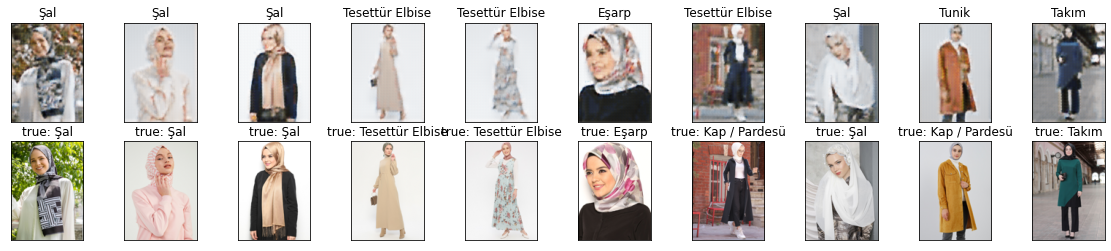

In [25]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(y_pred[0][i+16])
    
    plt.title(class_names[y_pred[1][i+16]])
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(test_gen.__getitem__(1)[0][i])
    st = "true: "+str(class_names[np.argmax(test_gen.__getitem__(1)[1][1][i])])
    plt.title(st)
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [15]:
test_gen.__getitem__(1)[1][1]

array([[0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.]])

In [ ]:
params = {'dim': (32,32,32),
          'batch_size': BATCH_SIZE,
          'n_classes': num_classes,
          'n_channels': 1,
          'shuffle': True}

# Generators
train_gen = AEDataGenerator( file_list[:40000], **params) #train generator
val_gen = AEDataGenerator( file_list[40000:48032], **params)

im_height= 136
im_width = 100
im_size = (im_height,im_width,3)

# encoder
input_layer = tf.keras.Input(shape=im_size)
encoder = Conv2D(filters=32, strides=(3, 3), activation='relu', padding='same', strides=2)(input_layer)
encoder = Conv2D(8, (3, 3), activation='relu', padding='same', strides=2, name="encoder")(encoder)

encoder_model = tf.keras.Model(input_layer, encoder, name="encoder")

# decoder
decoder = Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same')(encoder)
decoder = Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same')(decoder)
decoder = Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same', name="decoder")(decoder)

autoencoder = tf.keras.Model(input_layer, decoder, name="autoencoder")

clsf =  tf.keras.layers.Flatten()(encoder)
clsf = tf.keras.layers.Dropout(0.2)(clsf)
clsf =  tf.keras.layers.Dense( 64, activation='relu')(clsf)
clsf =  tf.keras.layers.Dense( 32, activation='relu')(clsf)
y = tf.keras.layers.Dense(num_classes, activation= 'softmax', name="classifier")(clsf)


conv_ae_cl = tf.keras.Model(inputs= input_layer,outputs= [decoder, y])
losses = {
    "classifier": "categorical_crossentropy",
    "decoder": "MeanSquaredError",
}
conv_ae_cl.compile( loss = losses, loss_weights={"classifier":0.1, "decoder":1},
                    metrics= ['accuracy'] , optimizer="adam")
